In [46]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import os
from PIL import Image
import tifffile as tiff

In [47]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, stride=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, stride=1),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_channels=9):  # 3 for RGB + 6 for disaster label ## CHANGE FOR DIFFERENT LABELING TECHNIQUE
        super(Generator, self).__init__()
        
        # Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, padding=3, stride=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, padding=1, stride=2),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        # Layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, padding=1, stride=2),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Layers 4-9: Residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(6)]
        )
        
        # Layer 10: Deconv
        self.layer10 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        # Layer 11: Deconv
        self.layer11 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Layer 12: Output layer
        self.layer12 = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=7, padding=3, stride=1),
            nn.Tanh()
        )

    def forward(self, x, disaster_label):
        # Concatenate image with label
        disaster_label = disaster_label.view(disaster_label.size(0), -1, 1, 1)
        disaster_label = disaster_label.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, disaster_label], dim=1)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.residual_blocks(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        
        return x 

In [48]:
def generate_fake_image(pre_image, disaster_onehot, checkpoint_path, device):
    generator = Generator().to(device)
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator.eval()

    pre_image = pre_image.to(device).unsqueeze(0)
    disaster_onehot = disaster_onehot.to(device).unsqueeze(0)

    with torch.no_grad():
        fake_image = generator(pre_image, disaster_onehot)

    pre_image_np = pre_image.squeeze(0).cpu().permute(1, 2, 0).numpy()
    pre_image_np = (pre_image_np * 255).clip(0, 255).astype('uint8')

    fake_image_np = fake_image.squeeze(0).cpu().permute(1, 2, 0).numpy()
    fake_image_np = (fake_image_np * 255).clip(0, 255).astype('uint8')

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(pre_image_np)
    plt.title("Original Pre Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(fake_image_np)
    plt.title("Generated Fake Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return fake_image

In [49]:
def load_pre_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image)

In [50]:
def one_hot_disaster(disaster_name):
    
    disaster_to_idx = {
        'flooding': 0,
        'wind': 1,
        'earthquake': 2,
        'tsunami': 3,
        'fire': 4,
        'volcano': 5
    }
    if disaster_name not in disaster_to_idx:
        raise ValueError(f"Invalid disaster name: {disaster_name}. Must be one of {list(disaster_to_idx.keys())}")
    
    index = disaster_to_idx[disaster_name]
    one_hot = torch.zeros(len(disaster_to_idx))
    one_hot[index] = 1.0
    return one_hot

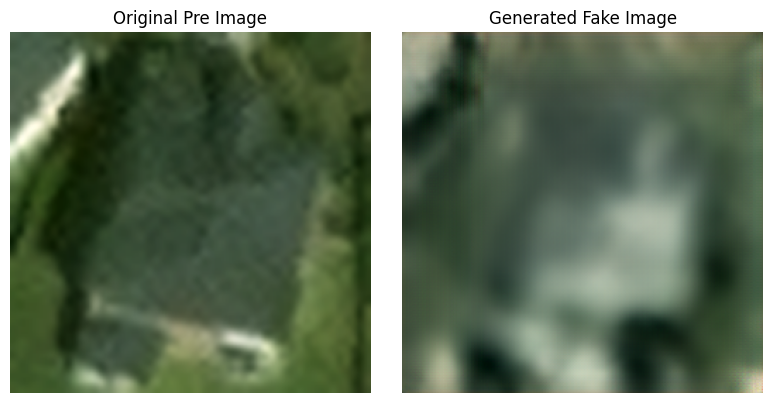

In [55]:
pre_image_path = load_pre_image("./tier1/cropped_square_buildings/aa5dc150-353b-4503-b761-31ac97c0b5dd_pre.png")
disaster = one_hot_disaster("e")
checkpoint_path = 'checkpoints/latest.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator_tensor = generate_fake_image(pre_image_path, disaster, checkpoint_path, device)

In [7]:
class Generator_Image(nn.Module):
    def __init__(self, input_channels=8):  # 3 for RGB + 5 for disaster label ## CHANGE FOR DIFFERENT LABELING TECHNIQUE
        super(Generator_Image, self).__init__()
        
        # Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, padding=3, stride=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, padding=1, stride=2),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        # Layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, padding=1, stride=2),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Layers 4-9: Residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(6)]
        )
        
        # Layer 10: Deconv
        self.layer10 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        # Layer 11: Deconv
        self.layer11 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Layer 12: Output layer
        self.layer12 = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=7, padding=3, stride=1),
            nn.Tanh()
        )
        
    def forward(self, x, disaster_label=5):
        # Concatenate the input image with the disaster label
        disaster_label = disaster_label.view(disaster_label.size(0), -1, 1, 1)
        disaster_label = disaster_label.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, disaster_label], dim=1)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.residual_blocks(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        
        return x 

In [8]:
def generate_fake_tif(pre_image, disaster_onehot, checkpoint_path, device):
    generator = Generator_Image().to(device)
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    generator.eval()

    pre_image = pre_image.to(device).unsqueeze(0)
    disaster_onehot = disaster_onehot.to(device).unsqueeze(0)

    with torch.no_grad():
        fake_image = generator(pre_image, disaster_onehot)

    pre_image_np = pre_image.squeeze(0).cpu().permute(1, 2, 0).numpy()
    pre_image_np = (pre_image_np * 255).clip(0, 255).astype('uint8')

    fake_image_np = fake_image.squeeze(0).cpu().permute(1, 2, 0).numpy()
    fake_image_np = (fake_image_np * 255).clip(0, 255).astype('uint8')

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(pre_image_np)
    plt.title("Original Pre Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(fake_image_np)
    plt.title("Generated Fake Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return fake_image

In [9]:
def one_hot_tif_disaster(disaster_name):
    
    disaster_to_idx = {
        'hurricane': 0,
        'michael': 0,
        'harvey': 0,
        'florence': 0,
        'matthew': 0,
        'flooding': 0,
        'fire': 1,
        'wildfire': 1,
        'earthquake': 2,
        'tsunami': 3,
        'volcano': 4
    }
    
    if disaster_name not in disaster_to_idx:
        raise ValueError(f"Invalid disaster name: {disaster_name}. Must be one of {list(disaster_to_idx.keys())}")
    
    index = disaster_to_idx[disaster_name]
    one_hot = torch.zeros(5)
    one_hot[index] = 1.0
    return one_hot

In [10]:
def load_pre_tif(tif_path):
    image = tiff.imread(tif_path)
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
        
    image = image.astype(np.float32) / 255.0
    image = torch.from_numpy(image).permute(2, 0, 1)
    
    image = torch.nn.functional.interpolate(
        image.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False
    ).squeeze(0)

    return image

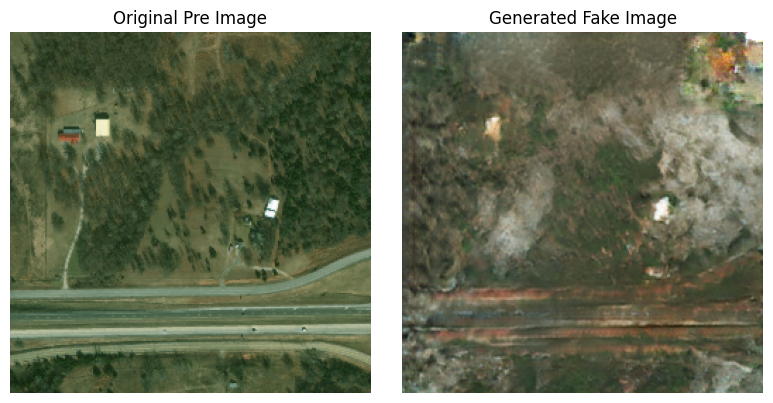

In [20]:
pre_tif_path = load_pre_tif("./tier1/images/midwest-flooding_00000191_pre_disaster.tif")
disaster = one_hot_tif_disaster("tsunami")
checkpoint_path = 'checkpoints/DisasterGAN_latest.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator_tensor = generate_fake_tif(pre_tif_path, disaster, checkpoint_path, device)